# DQN for Ms Pacman


**TLDR:** This notebook provides an implementation of a reinforcement learning agent using a deep q network to play Ms. Pac-Man.
<br>
<br>
$\rightarrow$ a detailed description is provided in [README.md](README.md) or [Project Documentation]()


## Table of Content


1. [Environment](#environment)
2. [Training](#train-agent)
3. [Evaluation](#evaluation)


## Imports


In [1]:
import collections
import os
import tempfile
import time
import warnings

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import Video
from tqdm import tqdm

from src.DQN import DQN
from src.ReplayBuffer import ReplayBuffer
from src.utils import create_plots, preprocess_frame, preprocess_state

# for windows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for mac
device = torch.device(
    "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)

warnings.simplefilter("ignore")
np.random.seed(187)
plt.style.use("fivethirtyeight")

## Environment


In [2]:
ENV_NAME = "ALE/MsPacman-v5"
env = gym.make(ENV_NAME, render_mode="rgb_array")

print("Observation Space: ", env.observation_space)
print("Action Space: ", env.action_space)
print("Actions: ", env.get_action_meanings())

Observation Space:  Box(0, 255, (210, 160, 3), uint8)
Action Space:  Discrete(9)
Actions:  ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


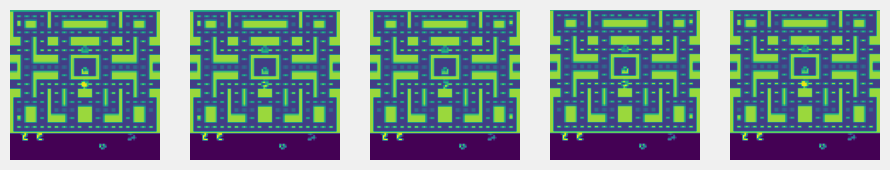

In [3]:
# plot sample states
obs, info = env.reset()

fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=5)
for i in range(5):
    obs, reward, done, trunc, info = env.step(env.action_space.sample())
    obs = preprocess_frame(obs)

    axes[i].imshow(obs)
    axes[i].axis("off")


env.close()

## Train Agent


### Set Parameter


In [4]:
GAMMA = 0.99
N_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_END = 0.01
# uncomment the following line to use a exponential decay for epsilon
# EPSILON_DECAY = 0.995
# uncomment the following line to use a linear decay for epsilon
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_EPISODES
LEARNING_RATE = 1e-4
REPLAY_SIZE = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 10
MAX_STEPS = 1000
N_STACKED_FRAMES = 4
INPUT_SHAPE = (4, 84, 84)

# create experience tuple template
Experience = collections.namedtuple(
    "Experience", field_names=["state", "action", "reward", "done", "next_state"]
)

### Create Instances


In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array")

dqn = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net.load_state_dict(dqn.state_dict())
target_net.eval()

optimizer = optim.Adam(dqn.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(capacity=REPLAY_SIZE)

### Train Loop


In [6]:
epsilon = EPSILON_START
frame_idx = 0
episode_rewards = list()
episode_durations = list()
losses = list()
epsilons = list()

with tempfile.TemporaryDirectory() as checkpoint_dir:
    for episode in tqdm(range(1, N_EPISODES + 1), total=N_EPISODES, desc="Training"):
        frame_stack = collections.deque(maxlen=N_STACKED_FRAMES)
        start = time.time()
        state, info = env.reset()
        state = preprocess_state(
            state,
            frame_stack=frame_stack,
            stack_size=N_STACKED_FRAMES,
        ).to(device)

        done = False
        total_reward = 0
        while not done or frame_idx < MAX_STEPS:

            # use epsilon greedy strategy to select action
            if np.random.rand() <= epsilon:
                action = np.random.randint(env.action_space.n)
            else:
                action = dqn(state).argmax().item()

            # act in environment
            next_state, reward, done, trunc, info = env.step(action)
            done = done or trunc
            # preprocess state
            next_state = preprocess_state(
                next_state,
                frame_stack=frame_stack,
                stack_size=N_STACKED_FRAMES,
            ).to(device)
            total_reward += reward

            # store information in replay buffer
            exp = Experience(state, action, reward, done, next_state)
            replay_buffer.push(exp)
            state = next_state

            frame_idx += 1

            # restore experiences from replay buffer
            if replay_buffer.size > BATCH_SIZE:
                (
                    sample_states,
                    sample_actions,
                    sample_rewards,
                    sample_dones,
                    sample_next_states,
                ) = replay_buffer.sample(BATCH_SIZE)

                # format samples as tensors
                sample_states = torch.cat(sample_states).to(device)
                sample_actions = torch.LongTensor(sample_actions).to(device)
                sample_rewards = torch.FloatTensor(sample_rewards).to(device)
                sample_next_states = torch.cat(sample_next_states).to(device)
                sample_dones = torch.FloatTensor(sample_dones).to(device)

                # calculate q values
                q_curr_state = (
                    dqn(sample_states)
                    .gather(1, sample_actions.unsqueeze(-1))
                    .squeeze(1)
                )
                q_next_state = target_net(sample_next_states).max(dim=1)[0]
                expected_q = sample_rewards + GAMMA * q_next_state * (1 - sample_dones)

                # calculate loss
                loss = nn.MSELoss()(q_curr_state, expected_q)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(dqn.parameters(), 1.0)
                optimizer.step()

        # update target network
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(dqn.state_dict())

        # update epsilon
        # uncomment the following line to use a exponential decay for epsilon
        # epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        # uncomment the following line to use a linear decay for epsilon
        epsilon = max(EPSILON_END, epsilon - EPSILON_DECAY)

        # save episode information
        episode_rewards.append(total_reward)
        episode_durations.append(time.time() - start)
        epsilons.append(epsilon)
        losses.append(loss.item())

        if episode % 200 == 0:
            create_plots(
                episode_rewards=episode_rewards,
                episode_lengths=episode_durations,
                episode_losses=losses,
                episode_epsilons=epsilons,
                save_fig=True,
                save_path=os.path.join("images", f"results_{episode}"),
            )

        # save model checkpoint
        if episode % 100 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{episode}.pth")
            torch.save(
                {
                    "episode": episode,
                    "model_state": dqn.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "loss": loss,
                    "epsilon": epsilon,
                },
                checkpoint_path,
            )

env.close()

# save model
torch.save(dqn.state_dict(), "agent-1.pth")
checkpoint_dir.cleanup()

Training:   0%|          | 5/1000 [00:40<2:03:41,  7.46s/it]

## Evaluation


In [ ]:
# create evaluation environment
eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
# uncomment the following line to record a video for each episode
# eval_env = gym.wrappers.RecordVideo(
#     eval_env, "videos_new", episode_trigger=lambda x: True
# )

# uncomment the following line to load the model from saved file
dqn = DQN(INPUT_SHAPE, eval_env.action_space.n).to(device)
dqn.load_state_dict(torch.load("agent.pth"))
dqn.eval()

# evaluation loop
eval_episode_rewards = list()
eval_episode_durations = list()

for episode in tqdm(range(1, N_EPISODES), total=N_EPISODES, desc="Evaluation"):
    start = time.time()
    state, info = eval_env.reset()
    state = preprocess_state(
        state, stack_states=True, stack_size=N_STACKED_FRAMES, create_tensor=True
    ).to(device)

    done = False
    total_reward = 0
    while not done:
        # since we are evaluating the model, we use greedy strategy
        action = dqn(state).argmax().item()
        next_state, reward, done, _, info = eval_env.step(action)
        next_state = preprocess_state(
            next_state,
            stack_states=True,
            stack_size=N_STACKED_FRAMES,
            create_tensor=True,
        ).to(device)
        total_reward += reward
        state = next_state

    eval_episode_rewards.append(total_reward)
    eval_episode_durations.append(time.time() - start)

eval_env.close()

In [ ]:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(
    np.arange(len(eval_episode_rewards)),
    eval_episode_rewards,
    label="Episode Rewards",
)
mvg_avg_reward = pd.Series(eval_episode_rewards).rolling(10).mean().dropna()
axes[0].plot(np.arange(len(mvg_avg_reward)), mvg_avg_reward, label="Moving Average")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].set_title("Evaluation Episode Rewards")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(
    np.arange(len(eval_episode_durations)), eval_episode_durations, label="Duration"
)
mvg_avg_duration = pd.Series(eval_episode_durations).rolling(10).mean().dropna()
axes[1].plot(np.arange(len(mvg_avg_duration)), mvg_avg_duration, label="Moving Average")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Duration")
axes[1].set_title("Evaluation Episode Durations\n (in seconds)")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()

In [ ]:
print("Average Training Episode Reward: ", np.mean(episode_rewards))
print(
    "Average Trian Episode Duration: ", round(np.mean(episode_durations), 2), " seconds"
)
print()
print("Average Evaluation Episode Reward: ", round(np.mean(eval_episode_rewards), 2))
print(
    "Average Evaluation Episode Duration: ",
    round(np.mean(eval_episode_durations), 2),
    " seconds",
)

In [ ]:
print("best episode reward: ", max(eval_episode_rewards))

### Display Episodes


In [ ]:
print("First Episode Reward: ", episode_rewards[0])
Video("videos/first-episode.mp4", width=400, height=400)

In [ ]:
print("Best Episode Reward: ", np.max(eval_episode_rewards))
Video(
    f"videos/best-episode.mp4",
    width=400,
    height=400,
)